In [1]:
# get tuned alg results for each split separately

import pandas as pd
import numpy as np

metadataset_df = pd.read_csv("./results/tuned_fold_results.csv")


# Develop outcome measures for each dataset split

In [2]:
# categorize each alg

neural_algs = [
    "MLP",
    "TabNet",
    "VIME",
    "TabTransformer",
    "NODE",
    "STG",
    "NAM",
    "DeepFM",
    "SAINT",
    "DANet",
    "rtdl_MLP",
    "rtdl_ResNet",
    "rtdl_FTTransformer",
    "TabPFNModel"
]

tree_algs = [
    "LightGBM",
    "XGBoost",
    "CatBoost",
    "RandomForest",

]

baseline_algs = [
    "DecisionTree",
    "LinearModel",
    "KNN",
    "SVM",
]

metadataset_df.loc[:, "alg_type"] = "baseline"
metadataset_df.loc[metadataset_df["alg_name"].isin(neural_algs), "alg_type"] = "neural"
metadataset_df.loc[metadataset_df["alg_name"].isin(tree_algs), "alg_type"] = "trees"

print(metadataset_df.groupby("alg_type")["alg_name"].value_counts())

alg_type  alg_name          
baseline  DecisionTree          1710
          LinearModel           1670
          KNN                   1640
          SVM                   1430
neural    rtdl_MLP              1710
          MLP                   1700
          rtdl_ResNet           1700
          TabNet                1660
          STG                   1630
          VIME                  1620
          DANet                 1470
          rtdl_FTTransformer    1390
          NODE                  1380
          TabTransformer        1220
          SAINT                 1060
          DeepFM                 900
          NAM                    800
          TabPFNModel            630
trees     XGBoost               1710
          RandomForest          1700
          LightGBM              1640
          CatBoost              1630
Name: alg_name, dtype: int64


## Clean metafeatures
- remove feats with nan
- remove redundant features (those with eqaul values for all datasets)

In [215]:
from metadata_utils import process_metafeatures

metafeatures_df = pd.read_csv("../TabSurvey/metafeatures.csv")
metafeatures_processed = process_metafeatures(metafeatures_df, filter_families=None)


/Users/duncan/research/active_projects/tabzilla/tabzilla_analysis/metadata_utils.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  metafeatures_processed = metafeatures_df.fillna(metafeatures_df.median())


In [257]:
def cor(x, y):
    return np.corrcoef(x, y)[0, 1]

In [10]:

all_feature_cols = [c for c in metafeatures_df.columns if c.startswith("f__")]

# no_nan_metafeatures = metafeatures_df[all_feature_cols].isna().sum() == 0
# print(f"number of metafeatures with no nans: {sum(no_nan_metafeatures)}")
# print(f"number of metafeatures with nans:    {sum(~no_nan_metafeatures)}")

# get features with no NaNs
# no_nan_feats = list(no_nan_metafeatures[no_nan_metafeatures].index)

# find and remove/record redundant features
redundant_feats = []
for i, feat in enumerate(all_feature_cols):
    if feat in redundant_feats:
        continue
    for j in range(i + 1, len(all_feature_cols)):
        if (metafeatures_processed[feat] == metafeatures_processed[all_feature_cols[j]]).all():
            print(f"removing feat: {all_feature_cols[j]} (equal to {feat}")
            redundant_feats.append(all_feature_cols[j])
        elif cor(metafeatures_processed[feat].values, metafeatures_processed[all_feature_cols[j]].values) > 0.999:
            print(f"removing feat: {all_feature_cols[j]} (corr with {feat}")
            redundant_feats.append(all_feature_cols[j])

redundant_feats = list(set(redundant_feats))

print(f"removing {len(redundant_feats)} redundant features:")
# for f in redundant_feats: print(f)

# keep only features which have no NaNs and are not redundant
keep_feats = [f for f in all_feature_cols if f not in redundant_feats]

# final dataset
keep_metafeatures_df = metafeatures_processed.loc[:, ["dataset_name"] + keep_feats]

keep_metafeatures_df.loc[:, "dataset_family"] = keep_metafeatures_df["dataset_name"].apply(lambda x: x[:-len("__fold_x")])

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


removing feat: f__pymfe.landmarking.elite_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.linear_discr.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.naive_bayes.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.one_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.random_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.worst_node.count (equal to f__pymfe.landmarking.best_node.count


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


removing feat: f__pymfe.relative.best_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.elite_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.linear_discr.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.naive_bayes.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.one_nn.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.random_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.relative.worst_node.count (equal to f__pymfe.landmarking.best_node.count
removing feat: f__pymfe.landmarking.elite_nn.count.relative (equal to f__pymfe.landmarking.best_node.count.relative
removing feat: f__pymfe.landmarking.linear_discr.count.relative (equal to f__pymfe.landmarking.best_node.count.relative
removing feat: f__pymfe.landmarking.naive_bayes.count.relative (equal to f__pymfe.landma

In [35]:
# save this as "cleaned" metafeatures
keep_metafeatures_df.to_csv("./results/cleaned_metafeatures.csv", index="dataset_name")

In [12]:
################
# IF CLEANED METAFEATURES HAS ALREADY BEEN WRITTEN
keep_metafeatures_df = pd.read_csv("./results/cleaned_metafeatures.csv", index_col=0)

# drop cols that are all NaN

# keep_metafeatures_df.loc[keep_metafeatures_df.isna().sum() > 0, :]
na_feats = keep_metafeatures_df.isna().sum() == len(keep_metafeatures_df)
na_feat_names = list(na_feats[na_feats].index)
print(f"dropping cols with only NA: {na_feat_names}")
keep_metafeatures_df.drop(columns=na_feat_names, inplace=True)

# replace inf with something else
keep_metafeatures_df.replace([np.inf, -np.inf], 0.0, inplace=True)

dropping cols with only NA: ['f__pymfe.statistical.iq_range', 'f__pymfe.statistical.t_mean']


In [14]:
# add log of all features
feature_cols = [c for c in keep_metafeatures_df.columns if c.startswith("f__")]
for f in feature_cols:
    if (keep_metafeatures_df.loc[:, f] > 0).all():
        keep_metafeatures_df.loc[:, f"{f}_LOG"] = np.log(keep_metafeatures_df.loc[:, f])

# keep_metafeatures_df.loc[keep_metafeatures_df.isna().sum() > 0, :]
na_feats = keep_metafeatures_df.isna().sum() == len(keep_metafeatures_df)
na_feat_names = list(na_feats[na_feats].index)
print(f"dropping cols with only NA: {na_feat_names}")
keep_metafeatures_df.drop(columns=na_feat_names, inplace=True)


dropping cols with only NA: []


In [15]:
keep_metafeatures_df.head()

,dataset_name,f__pymfe.landmarking.best_node.count,f__pymfe.landmarking.best_node.count.relative,f__pymfe.landmarking.best_node.histogram.0,f__pymfe.landmarking.best_node.histogram.0.relative,f__pymfe.landmarking.best_node.histogram.1,f__pymfe.landmarking.best_node.histogram.1.relative,f__pymfe.landmarking.best_node.histogram.2,f__pymfe.landmarking.best_node.histogram.2.relative,f__pymfe.landmarking.best_node.histogram.3,...,f__pymfe.general.nr_inst_LOG_LOG,f__pymfe.statistical.sd_ratio_LOG_LOG,f__pymfe.model-based.leaves_LOG_LOG,f__pymfe.model-based.leaves_homo.max_LOG_LOG,f__pymfe.model-based.leaves_homo.median_LOG_LOG,f__pymfe.model-based.leaves_homo.min_LOG_LOG,f__pymfe.model-based.leaves_homo.quantiles.1_LOG_LOG,f__pymfe.model-based.leaves_per_class.count_LOG_LOG,f__pymfe.info-theory.eq_num_attr_LOG_LOG,f__pymfe.info-theory.joint_ent.max_LOG_LOG
0,openml__cjs__14967__fold_0,10,4.0,0.3,6.5,0.0,2.5,0.2,6.5,0.2,...,2.042835,-1.579739,1.827865,2.760445,2.489351,1.933510,2.384117,0.583198,-0.404333,0.540568
1,openml__cjs__14967__fold_1,10,4.0,0.1,4.0,0.0,3.0,0.0,2.5,0.2,...,2.042835,-1.579739,1.833194,2.877253,2.541586,1.938306,2.387176,0.583198,-0.402672,0.542031
2,openml__cjs__14967__fold_2,10,4.0,0.3,7.0,0.1,5.5,0.1,4.5,0.0,...,2.042835,-1.579739,1.829769,2.911842,2.539901,1.935224,2.385209,0.583198,-0.408526,0.542915
3,openml__cjs__14967__fold_3,10,4.0,0.1,3.5,0.1,4.5,0.1,6.0,0.3,...,2.042835,-1.579739,1.830712,2.980406,2.540364,1.936072,2.385750,0.583198,-0.411540,0.541857
4,openml__cjs__14967__fold_4,10,4.0,0.1,3.5,0.1,6.5,0.1,5.5,0.4,...,2.042835,-1.579739,1.828820,2.911521,2.539434,1.934370,2.384665,0.583198,-0.405945,0.540684


## merge performance dataset with metafeatures

In [16]:
# get best-performing alg type for each dataset split
best_alg_df_dict = {}
neural_tree_diff_dict = {}

metric_list = [
    "Accuracy",
    "F1",
    "Log Loss",
]

obj_type_list = [
    "max",
    "max",
    "min",
]

for metric, obj_type in zip(metric_list, obj_type_list):

    ####################################################################################
    # get the difference in metric between the best neural and tree alg for each dataset
    if obj_type == "max":
        tree_best = metadataset_df[metadataset_df["alg_type"] == "trees"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .max().reset_index()
        neural_best = metadataset_df[metadataset_df["alg_type"] == "neural"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .max().reset_index()
        baseline_best = metadataset_df[metadataset_df["alg_type"] == "baseline"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .max().reset_index()
    elif obj_type == "min":
        tree_best = metadataset_df[metadataset_df["alg_type"] == "trees"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .min().reset_index()
        neural_best = metadataset_df[metadataset_df["alg_type"] == "neural"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .min().reset_index()
        baseline_best = metadataset_df[metadataset_df["alg_type"] == "baseline"].groupby("dataset_fold_id")[f"normalized_{metric}__test"] \
            .min().reset_index()

    # merge these and get the difference & abs-difference
    baseline_best.rename(columns={f"normalized_{metric}__test": f"normalized_{metric}__test_baseline"}, inplace=True)
    neural_tree_diff = neural_best.merge(tree_best, on="dataset_fold_id", suffixes=["_neural", "_trees"], how="inner").merge(baseline_best, on="dataset_fold_id")

    neural_tree_diff.loc[:, "neural_tree_diff"] = neural_tree_diff[f"normalized_{metric}__test_neural"] - neural_tree_diff[f"normalized_{metric}__test_trees"]
    neural_tree_diff.loc[:, "abs_neural_tree_diff"] = neural_tree_diff.loc[:, "neural_tree_diff"].abs()

    neural_tree_diff_dict[metric] = neural_tree_diff

    #################################
    # # define the "top-ranked" algs

    # df_metric = metadataset_df.loc[metadataset_df[f"{metric}_rank"] == 1, :]
    df_metric = metadataset_df.loc[metadataset_df[f"normalized_{metric}__test"] >= 0.99, :]

    # get a list of all top-ranked algs for each dataset split
    best_algs = df_metric.groupby("dataset_fold_id")["alg_type"].apply(lambda x: set(x)).reset_index()

    # add a binary col indicating whether best alg includes each alg class
    for alg_type in ["trees", "neural", "baseline"]:
        best_algs.loc[:, f"{alg_type}_win"] = best_algs["alg_type"].apply(lambda x: 1 if alg_type in x else 0)

    best_alg_df_dict[metric] = best_algs

In [17]:
# len(best_alg_df_dict["Accuracy"]["dataset_fold_id"].unique()) # 1705
set(metadataset_df["dataset_fold_id"].unique()).difference(best_alg_df_dict["Accuracy"]["dataset_fold_id"].unique())

# which folds are missing?

{'openml__postoperative-patient-data__146210__fold_7',
 'openml__rabe_266__3647__fold_7',
 'openml__solar-flare__2068__fold_0',
 'openml__solar-flare__2068__fold_1',
 'openml__solar-flare__2068__fold_8'}

In [18]:
# there are errors with these splits.

In [19]:
# merge on dataset split name
for metric in metric_list:
    neural_tree_diff_dict[metric] = neural_tree_diff_dict[metric].merge(keep_metafeatures_df, left_on="dataset_fold_id", right_on="dataset_name", how="left")
    best_alg_df_dict[metric] = best_alg_df_dict[metric].merge(keep_metafeatures_df, left_on="dataset_fold_id", right_on="dataset_name", how="left")

# Q0: LDA for deciding when neural nets exclusively win

In [55]:
df = best_alg_df_dict["Accuracy"].copy()

df.loc[:, "outcome"] = "none"
df.loc[((1 - df["baseline_win"]) & df["trees_win"] & df["neural_win"]) == 1, "outcome"] = 0 # "non-neural"
df.loc[df["baseline_win"] == 1, "outcome"] = 0 #"non-neural"
df.loc[((1 - df["baseline_win"]) & df["trees_win"] & (1 - df["neural_win"])) == 1, "outcome"] = 0 # "non-neural"
df.loc[((1 - df["baseline_win"]) & (1 - df["trees_win"]) & df["neural_win"]) == 1, "outcome"] = 1 #"neural"

x = df.loc[:, feature_cols].values
y = df["outcome"].values

In [59]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(x, y).transform(x)
# print(X_r2.shape)

# run a logistic regression on accuracy using dataset metafeatures
from sklearn.linear_model import LogisticRegression

# clf = LassoCV(cv=3, random_state=0).fit(x, y)
clf = LogisticRegression(penalty="l1", solver="saga", max_iter=5000, C=1e1).fit(x, y)

/Users/duncan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([0, 0, 0, ..., 0, 0, 1])

# Q1: when do neural and tree algs have different performance?

In [20]:

def simplify(x):
    return x.replace("statistical", "stat").replace("model-based", "model").replace("landmarking", "landmark").replace("skewness", "skew")

nice_feature_names = [simplify(f[len("f__pymfe."):]) for f in feature_cols]

In [21]:
# find correlation between each feature and abs. feat. diff

def cor(x, y):
    return np.corrcoef(x, y)[0, 1]
    
target_col = "abs_neural_tree_diff"

df = neural_tree_diff_dict["Accuracy"
]
corrs = [cor(df[f], df[target_col]) for f in feature_cols]

print("highest-correlated features with abs diff:")
abs_coef = np.abs(corrs)

idx_sorted_q1a = (-abs_coef).argsort()

num_print_feats = 30

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_q1a[i]]}: {abs_coef[idx_sorted_q1a[i]]}")

q1a_keep_idx = idx_sorted_q1a[:30]


highest-correlated features with abs diff:
landmark.best_node.count: nan
model.var_importance.quantiles.1: nan
model.var_importance.min: nan
model.var_importance.median: nan
model.var_importance.mean: nan
model.var_importance.max: nan
model.var_importance.kurtosis: nan
model.var_importance.iq_range: nan
model.var_importance.histogram.9: nan
model.var_importance.histogram.8: nan
model.var_importance.histogram.7: nan
model.var_importance.histogram.6: nan
model.var_importance.histogram.5: nan
model.var_importance.histogram.4: nan
model.var_importance.histogram.3: nan
model.var_importance.histogram.2: nan
model.var_importance.quantiles.3: nan
model.var_importance.range: nan
model.var_importance.sd: nan
model.var_importance.skew: nan
info-theory.attr_conc.median: nan
info-theory.attr_conc.mean: nan
info-theory.attr_conc.max: nan
info-theory.attr_conc.kurtosis: nan
info-theory.attr_conc.iq_range: nan
info-theory.attr_conc.histogram.9: nan
info-theory.attr_conc.histogram.8: nan
model.var_impo

plotting feature f__pymfe.landmarking.best_node.count (corr with abs diff = nan
plotting feature f__pymfe.landmarking.best_node.count (corr with actual diff = nan
plotting feature f__pymfe.model-based.var_importance.quantiles.1 (corr with abs diff = nan
plotting feature f__pymfe.model-based.var_importance.quantiles.1 (corr with actual diff = nan
plotting feature f__pymfe.model-based.var_importance.min (corr with abs diff = nan
plotting feature f__pymfe.model-based.var_importance.min (corr with actual diff = nan
plotting feature f__pymfe.model-based.var_importance.median (corr with abs diff = nan
plotting feature f__pymfe.model-based.var_importance.median (corr with actual diff = nan
plotting feature f__pymfe.model-based.var_importance.mean (corr with abs diff = nan
plotting feature f__pymfe.model-based.var_importance.mean (corr with actual diff = nan
plotting feature f__pymfe.model-based.var_importance.max (corr with abs diff = nan
plotting feature f__pymfe.model-based.var_importance.m

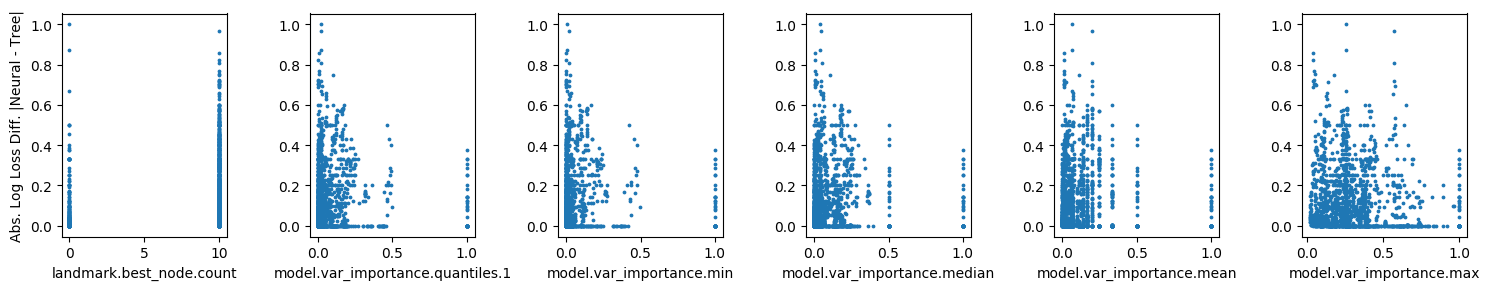

In [22]:
## plot diff abs diff with feature, for all datasets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(15, 3))

for i in range(6):
    plot_feat = feature_cols[idx_sorted_q1a[i]]
    feat_name = nice_feature_names[idx_sorted_q1a[i]]

    print(f"plotting feature {plot_feat} (corr with abs diff = {cor(df[plot_feat], df['abs_neural_tree_diff'])}")
    print(f"plotting feature {plot_feat} (corr with actual diff = {cor(df[plot_feat], df['neural_tree_diff'])}")

    axs[i].scatter(df[plot_feat], df["abs_neural_tree_diff"], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(f"Abs. {metric} Diff. |Neural - Tree|")

plt.tight_layout()


## Q1.b: actual difference between neural and tree methods

In [28]:
# find correlation between each feature and abs. feat. diff

target_col = "neural_tree_diff"

df = neural_tree_diff_dict["Accuracy"].copy()

df = df.loc[~df[target_col].isna(), :]

corrs = [cor(df[f], df[target_col]) for f in feature_cols]

print("highest-correlated features with ACTUAL diff:")
abs_coef = np.abs(corrs)

idx_sorted_q1b = (-abs_coef).argsort()

num_print_feats = 100

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_q1b[i]]}: {corrs[idx_sorted_q1b[i]]}")

q1b_keep_idx = idx_sorted_q1b[:30]



/Users/duncan/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/duncan/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


highest-correlated features with ACTUAL diff:
stat.skew.sd: -0.32560289312375834
model.tree_depth.histogram.9_LOG: 0.31479395078480354
general.nr_inst_LOG: -0.31021845722754515
model.nodes_per_level.median_LOG: -0.30946142252038544
stat.kurtosis.mean: -0.3069156134466626
model.leaves_corrob.histogram.9_LOG: 0.30577285977842844
model.nodes_per_level.mean_LOG: -0.3045672071545009
model.tree_shape.mean_LOG: 0.29603050691826044
model.leaves_corrob.mean_LOG: 0.29418546734507434
model.leaves_LOG: -0.2941853950601294
model.leaves_corrob.median_LOG: 0.29414153308489743
model.leaves_corrob.quantiles.3_LOG: 0.2933598081829533
model.leaves_corrob.iq_range_LOG: 0.2931833729657371
landmark.naive_bayes.max_LOG: 0.29307060083024916
model.nodes_per_level.max_LOG: -0.2919827229252867
model.leaves_corrob.min_LOG: 0.290861098011749
model.leaves_corrob.quantiles.1_LOG: 0.2897875605609339
stat.skew.mean: -0.28607653983068165
model.tree_shape.skew: -0.2855215963796055
model.leaves_homo.min_LOG: -0.284784347

In [29]:
# which families are the highly correlated features from?
feat_families = [f.split(".")[1] for i, f in enumerate(feature_cols) if abs_coef[i] > 0.2]
pd.value_counts(feat_families)

model-based    44
statistical    39
landmarking    19
general         4
dtype: int64

In [30]:
len(feat_families)

106

plotting feature f__pymfe.statistical.skewness.sd (corr with actual diff = -0.32560289312375834
plotting feature f__pymfe.statistical.skewness.sd (corr with log-actual diff = -0.25783970866548706
plotting feature f__pymfe.model-based.tree_depth.histogram.9_LOG (corr with actual diff = 0.31479395078480354
plotting feature f__pymfe.model-based.tree_depth.histogram.9_LOG (corr with log-actual diff = nan


/Users/duncan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


KeyError: 'f__pymfe.model-based.tree_depth.histogram.9_LOGf__pymfe.general.nr_inst_LOG'

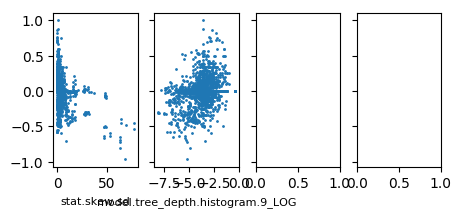

In [32]:
## plot diff real and abs diff with feature, for all datasets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(5, 2))

plot_feats = [
    # "f__pymfe.statistical.skewness.mean",
    # "f__pymfe.statistical.kurtosis.mean",
    # "f__pymfe.model-based.tree_shape.skewness",
    "f__pymfe.statistical.skewness.sd",
    "f__pymfe.model-based.tree_depth.histogram.9_LOG",
    "f__pymfe.model-based.tree_depth.histogram.9_LOG"
    "f__pymfe.general.nr_inst_LOG",
]

for i, plot_feat in enumerate(plot_feats):
    # plot_feat = feature_cols[idx_sorted_q1b[i]]
    # feat_name = nice_feature_names[idx_sorted_q1b[i]]
    feat_name = plot_feat[len("f__pymfe."):].replace("skewness", "skew").replace("statistical", "stat").replace("model-based", "model")

    print(f"plotting feature {plot_feat} (corr with actual diff = {cor(df[plot_feat], df['neural_tree_diff'])}")
    print(f"plotting feature {plot_feat} (corr with log-actual diff = {cor(np.log(df[plot_feat]), df['neural_tree_diff'])}")

    axs[i].scatter(df[plot_feat], df["neural_tree_diff"], s=1)

    axs[i].set_xlabel(feat_name, fontsize=8)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # axs[i].set_xscale("log")

axs[0].set_ylabel("$\Delta^{Acc}$ (Neural - GBDT)") #, fontname='Serif')

plt.savefig("./results/scatter_delta_nn_gbdt.pdf", bbox_inches="tight")
plt.tight_layout()


In [292]:
# # now plot a curated version 

# plot_feats = [
#     "f__pymfe.statistical.skewness.mean",
#     "f__pymfe.statistical.kurtosis.mean",
#     "f__pymfe.model-based.tree_shape.skewness",
# ]


# fig, axs = plt.subplots(1, len(plot_feats), figsize=(10, 3))

# for i, f in enumerate(plot_feats):
#     # plot_feat = plot_feats[f]
#     feat_name = f[len("f__pymfe."):]

#     print(f"plotting feature {f} (corr with actual diff = {cor(df_q1[f], df_q1['neural_tree_diff'])}")
#     print(f"plotting feature {f} (corr with log-actual diff = {cor(np.log(df_q1[f]), df_q1['neural_tree_diff'])}")

#     axs[i].scatter(df_q1[f], df_q1["neural_tree_diff"], s=3)

#     axs[i].set_xlabel(feat_name)
#     # ax.legend()
#     # ax.set_xlabel(feat_comparison[0])
#     # ax.set_ylabel(feat_comparison[1])

#     axs[i].set_xscale("log")

# axs[0].set_ylabel(f"{metric} diff. (Neural - Tree)")

# plt.tight_layout()

plotting feature f__pymfe.landmarking.naive_bayes.max (corr with actual diff = 0.2680801107436148
plotting feature f__pymfe.landmarking.naive_bayes.max (corr with log-actual diff = 0.29307060083024916
plotting feature f__pymfe.landmarking.linear_discr.max (corr with actual diff = 0.2598703119030153
plotting feature f__pymfe.landmarking.linear_discr.max (corr with log-actual diff = 0.27666846018353086
plotting feature f__pymfe.landmarking.elite_nn.max (corr with actual diff = 0.0009692405452178006
plotting feature f__pymfe.landmarking.elite_nn.max (corr with log-actual diff = 0.048061413469682464
plotting feature f__pymfe.landmarking.worst_node.max (corr with actual diff = 0.09092519890421147
plotting feature f__pymfe.landmarking.worst_node.max (corr with log-actual diff = 0.08844362210531465


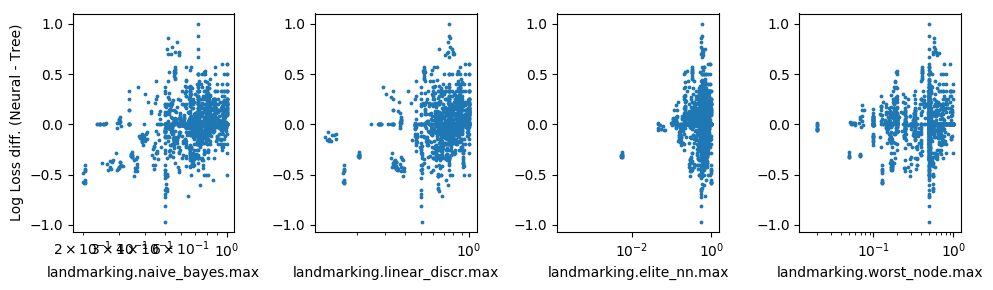

In [33]:
# now plot a curated version 

plot_feats = [
    "f__pymfe.landmarking.naive_bayes.max",
    "f__pymfe.landmarking.linear_discr.max",
    "f__pymfe.landmarking.elite_nn.max",
    # "f__pymfe.landmarking.one_nn.min",
    "f__pymfe.landmarking.worst_node.max",
]


fig, axs = plt.subplots(1, len(plot_feats), figsize=(10, 3))

for i, f in enumerate(plot_feats):
    # plot_feat = plot_feats[f]
    feat_name = f[len("f__pymfe."):]

    print(f"plotting feature {f} (corr with actual diff = {cor(df[f], df['neural_tree_diff'])}")
    print(f"plotting feature {f} (corr with log-actual diff = {cor(np.log(df[f]), df['neural_tree_diff'])}")

    axs[i].scatter(df[f], df["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    axs[i].set_xscale("log")

axs[0].set_ylabel(f"{metric} diff. (Neural - Tree)")

plt.tight_layout()

## Q1.c: predict diff with a tree ensemble to find important features

In [415]:

from xgboost import XGBClassifier, XGBRegressor


target_col = "neural_tree_diff"

x = df_q1[feature_cols].clip(-1e10, 1e10)
y = df_q1[target_col]

xgb_q1 = XGBRegressor(n_estimators=200, max_depth=5, early_stopping_rounds=5, use_label_encoder=False).fit(x, y)

print("xgb features with high importance:")


abs_coef = xgb_q1.feature_importances_

idx_sorted_xgb = (-abs_coef).argsort()

num_print_feats = 20

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_xgb[i]]}: {abs_coef[idx_sorted_xgb[i]]}")

q1c_keep_idx = idx_sorted_xgb[:30]


# # split indeces according to dataset "family" ()
# train_rows = df["dataset_family"].apply(lambda x: x in train_dataset_families)
# val_rows = ~train_rows

# y_train = df.loc[train_rows, target_col].values
# x_train = df.loc[train_rows, feature_cols].values

# y_val = df.loc[val_rows, target_col].values
# x_val = df.loc[val_rows, feature_cols].values



/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:02:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


xgb features with high importance:
model-based.nodes_per_level.mean: 0.11154535412788391
model-based.leaves_corrob.histogram.0: 0.06518882513046265
landmarking.elite_nn.quantiles.1.relative: 0.05612226948142052
landmarking.one_nn.mean.relative: 0.04587296396493912
statistical.skewness.max: 0.03587508574128151
statistical.can_cor.mean: 0.02869824506342411
statistical.cor.sd: 0.026290656998753548
statistical.kurtosis.iq_range: 0.025660289451479912
landmarking.elite_nn.min.relative: 0.0224112868309021
landmarking.naiv

## For Q1: plot "winning" algs using pairs of important features

In [432]:
# combine the features identified in all previous subsections
keep = 5
q1_feat_idx = list(set(q1a_keep_idx[:keep]).union(set(q1b_keep_idx[:keep])).union(set(q1c_keep_idx[:keep])))
q1_feats = [feature_cols[i] for i in q1_feat_idx]

# find a set of all feature *families* that are identified
q1_feat_family = list(set([".".join(f.split(".")[:3]) for f in q1_feats]))

print(f"{len(q1_feat_family)} identified ({len(q1_feats)} feats.):")
for f in q1_feat_family:
    print("\"" + f + "\",")

# how many meta-features overall, from these families?
final_q1_metafeats = [c for c in feature_cols if any([fam in c for fam in q1_feat_family])]
print(f"total num. feats from these families: {len(final_q1_metafeats)}")

13 identified (15 feats.):
"f__pymfe.model-based.leaves_homo",
"f__pymfe.landmarking.elite_nn",
"f__pymfe.model-based.leaves_corrob",
"f__pymfe.landmarking.linear_discr",
"f__pymfe.statistical.t_mean",
"f__pymfe.model-based.tree_shape",
"f__pymfe.statistical.skewness",
"f__pymfe.model-based.nodes_per_level",
"f__pymfe.landmarking.naive_bayes",
"f__pymfe.statistical.max",
"f__pymfe.landmarking.one_nn",
"f__pymfe.statistical.cov",
"f__pymfe.model-based.nodes_repeated",
total num. feats from these families: 332


In [430]:
final_q1_metafeats

['f__pymfe.landmarking.elite_nn.histogram.0',
 'f__pymfe.landmarking.elite_nn.histogram.0.relative',
 'f__pymfe.landmarking.elite_nn.histogram.1',
 'f__pymfe.landmarking.elite_nn.histogram.1.relative',
 'f__pymfe.landmarking.elite_nn.histogram.2',
 'f__pymfe.landmarking.elite_nn.histogram.2.relative',
 'f__pymfe.landmarking.elite_nn.histogram.3',
 'f__pymfe.landmarking.elite_nn.histogram.3.relative',
 'f__pymfe.landmarking.elite_nn.histogram.4',
 'f__pymfe.landmarking.elite_nn.histogram.4.relative',
 'f__pymfe.landmarking.elite_nn.histogram.5',
 'f__pymfe.landmarking.elite_nn.histogram.5.relative',
 'f__pymfe.landmarking.elite_nn.histogram.6',
 'f__pymfe.landmarking.elite_nn.histogram.6.relative',
 'f__pymfe.landmarking.elite_nn.histogram.7',
 'f__pymfe.landmarking.elite_nn.histogram.7.relative',
 'f__pymfe.landmarking.elite_nn.histogram.8',
 'f__pymfe.landmarking.elite_nn.histogram.8.relative',
 'f__pymfe.landmarking.elite_nn.histogram.9',
 'f__pymfe.landmarking.elite_nn.histogram.9.r

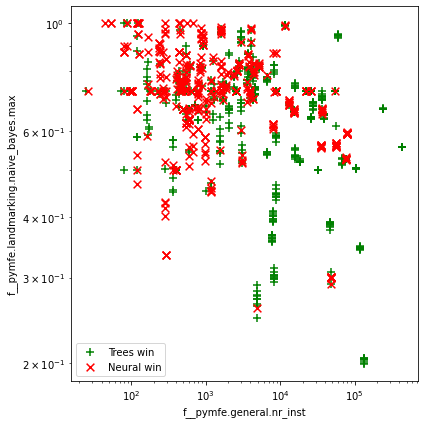

In [387]:
# plot winning-alg-class by feats...
import matplotlib.pyplot as plt

df = best_alg_df_dict["Accuracy"]

feat_comparison = [
#     "f__pymfe.statistical.mean.iq_range",
    # "f__pymfe.model-based.nodes_repeated.iq_range",     # ***
    # "f__pymfe.model-based.tree_depth.histogram.4",
#     "f__pymfe.statistical.min.quantiles.1",
    # "f__pymfe.landmarking.worst_node.sd",
#     "f__pymfe.general.freq_class.min",
    # "f__pymfe.model-based.tree_shape.sd",
    # "f__pymfe.model-based.tree_shape.skewness",
#     "f__pymfe.statistical.sd.iq_range",
    "f__pymfe.general.nr_inst",                           # ***
    # "f__pymfe.statistical.sd.min",
    # "f__pymfe.landmarking.elite_nn.min.relative",
    # "f__pymfe.model-based.var_importance.median",
    # "f__pymfe.statistical.can_cor.max",
    # "f__pymfe.statistical.can_cor.mean",
    # "f__pymfe.statistical.can_cor.median",
    # "f__pymfe.statistical.skewness.mean",
    # "f__pymfe.statistical.can_cor.quantiles.1",
    # "f__pymfe.statistical.can_cor.quantiles.3",
    # "f__pymfe.model-based.var_importance.quantiles.3",
    # "f__pymfe.statistical.skewness.sd",
    # "f__pymfe.statistical.cor.histogram.6",
    # "f__pymfe.statistical.sparsity.histogram.8",
    # "f__pymfe.statistical.cor.median",
    # "f__pymfe.statistical.cor.min",                 # **
    # "f__pymfe.landmarking.linear_discr.max",
    # "f__pymfe.landmarking.linear_discr.mean",
    # "f__pymfe.statistical.cor.sd",                # **
    # "f__pymfe.landmarking.linear_discr.median",
    # "f__pymfe.statistical.cov.histogram.0",
#     "f__pymfe.landmarking.linear_discr.min",
    # "f__pymfe.landmarking.linear_discr.quantiles.1",
    # "f__pymfe.statistical.cov.histogram.4",
    # "f__pymfe.landmarking.linear_discr.quantiles.3",
    # "f__pymfe.info-theory.attr_ent.histogram.9",
    # "f__pymfe.statistical.t_mean.histogram.6",
    # "f__pymfe.statistical.cov.iq_range",
    # "f__pymfe.statistical.t_mean.iq_range",
    # "f__pymfe.statistical.cov.max",                   # **
    # "f__pymfe.statistical.t_mean.median",
    # "f__pymfe.statistical.cov.min",                 # **
    # "f__pymfe.statistical.cov.quantiles.1",
    # "f__pymfe.statistical.t_mean.quantiles.3",
    # "f__pymfe.statistical.eigenvalues.histogram.6",
    # "f__pymfe.statistical.eigenvalues.min",             # **
    # "f__pymfe.statistical.w_lambda",
    "f__pymfe.landmarking.naive_bayes.max",         # ***
#     "f__pymfe.landmarking.naive_bayes.mean",
#     "f__pymfe.landmarking.naive_bayes.median",
    # "f__pymfe.landmarking.naive_bayes.min",
    # "f__pymfe.model-based.leaves_branch.iq_range",
#     "f__pymfe.landmarking.naive_bayes.quantiles.1",
#     "f__pymfe.landmarking.naive_bayes.quantiles.3",
#     "f__pymfe.statistical.h_mean.histogram.1",
    # "f__pymfe.model-based.leaves_corrob.histogram.0",
#     "f__pymfe.statistical.h_mean.iq_range",
    # "f__pymfe.statistical.h_mean.max",
#     "f__pymfe.statistical.h_mean.median",
#     "f__pymfe.statistical.h_mean.min",
    # "f__pymfe.statistical.h_mean.quantiles.3",
#     "f__pymfe.model-based.leaves_corrob.histogram.9",
    # "f__pymfe.statistical.iq_range.iq_range",
#     "f__pymfe.statistical.kurtosis.histogram.1",
#     "f__pymfe.model-based.leaves_homo.skewness",
    # "f__pymfe.statistical.kurtosis.iq_range",
    # "f__pymfe.statistical.kurtosis.mean",           # ***
#     "f__pymfe.statistical.kurtosis.sd",
#     "f__pymfe.statistical.mad.quantiles.3",
    # "f__pymfe.model-based.nodes_per_level.mean",      # ***
#     "f__pymfe.statistical.max.min",
    # "f__pymfe.model-based.nodes_per_level.quantiles.1",
    ######### others... #########
    # "f__pymfe.general.inst_to_attr",
    # "f__pymfe.statistical.nr_outliers",             # **
    # "f__pymfe.general.freq_class.count",
]

# feat_comparison = [
#     # "f__pymfe.statistical.skewness.mean",
#     # "f__pymfe.statistical.kurtosis.mean",
#     "f__pymfe.statistical.skewness.sd",
#     "f__pymfe.statistical.kurtosis.sd",
# ]

alg_type = df["alg_type"].astype(str).values
x = df[feat_comparison[0]].values
y = df[feat_comparison[1]].values


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# indices of each type of point
tree_wins = df["alg_type"] == {"trees"}
neural_wins = df["alg_type"] == {"neural"}
other_wins = ~(tree_wins + neural_wins)


# plot tree-only wins
ax.scatter(x[tree_wins], y[tree_wins], label="Trees win", s=60,
        marker="+",
        color="g",
)

# plot neural-only wins
ax.scatter(x[neural_wins], y[neural_wins], label="Neural win", s=60,
        marker="x",
        color="r",
)

# # plot everything else
# ax.scatter(x[other_wins], y[other_wins], label="Other", s=100,
#         marker="^",
#         color="gray",
#         alpha=0.2,
# )


ax.legend()
ax.set_xlabel(feat_comparison[0])
ax.set_ylabel(feat_comparison[1])

ax.set_yscale("log")
ax.set_xscale("log")

plt.tight_layout()


# Q2: Can we predict when baselines will perform well, regardless of whether other alg classes perform well.

In [40]:
# # create a train/val split based on dataset family.
# dataset_families = list(best_alg_df_dict['Accuracy']['dataset_family'].unique())
# print(f"number of dataset families: {len(best_alg_df_dict['Accuracy']['dataset_family'].unique())}")

# # randomly select 10 dataset families for validation
# seed = 0
# num_val_families = 12
# rs = np.random.RandomState(seed)
# val_inds = rs.choice(len(dataset_families), num_val_families)
# val_dataset_families = [dataset_families[i] for i in val_inds]
# train_dataset_families = [d for d in dataset_families if d not in val_dataset_families]


number of dataset families: 171


In [207]:
# first, train an XGB model to get an idea of how easy/hard this question is
from xgboost import XGBClassifier

metric = "Accuracy"
df = best_alg_df_dict[metric]

target_col = "neural_win"
feature_cols = [c for c in df.columns if c.startswith("f__")]
nice_feature_names = [f[len("f__pymfe."):] for f in feature_cols]

# split indeces according to dataset "family" ()
train_rows = df["dataset_family"].apply(lambda x: x in train_dataset_families)
val_rows = ~train_rows

y_train = df.loc[train_rows, target_col].values
x_train = df.loc[train_rows, feature_cols].values

y_val = df.loc[val_rows, target_col].values
x_val = df.loc[val_rows, feature_cols].values

# assess y
print(f"number of cases with y=1 (train): {sum(y_train==1)} of {len(y_train)} ({100. * sum(y_train==1) / len(y_train):.2f}%)")
print(f"number of cases with y=1 (val): {sum(y_val==1)} of {len(y_val)} ({100. * sum(y_val==1) / len(y_val):.2f}%)")


number of cases with y=1 (train): 972 of 1585 (61.32%)
number of cases with y=1 (val): 66 of 120 (55.00%)


In [208]:
xgb_q1 = XGBClassifier(n_estimators=150, max_depth=5, early_stopping_rounds=5, use_label_encoder=False).fit(x_train, y_train)

[16:53:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:53:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [209]:
from sklearn import metrics

yhat_val = xgb_q1.predict_proba(x_val)[:, 1]
yhat_class_val = xgb_q1.predict(x_val)
yhat_train = xgb_q1.predict_proba(x_train)[:, 1]
yhat_class_train = xgb_q1.predict(x_train)


# evaluate on train and val set
auc_val = metrics.roc_auc_score(y_val, yhat_val)
auc_train = metrics.roc_auc_score(y_train, yhat_train)
f1_val = metrics.f1_score(y_val, yhat_class_val)
f1_train = metrics.f1_score(y_train, yhat_class_train)
acc_val = metrics.accuracy_score(y_val, yhat_class_val)
acc_train = metrics.accuracy_score(y_train, yhat_class_train)
# tn_val, fp_val, fn_val, tp_val = metrics.confusion_matrix(y_val, yhat_class_val).ravel()
# tn_train, fp_train, fn_train, tp_train = metrics.confusion_matrix(y_train, yhat_class_train).ravel()

print(f"ROC-AUC (val): {auc_val:.2f} | (train): {auc_train:.2f}")
print(f"F1      (val): {f1_val:.2f} | (train): {f1_train:.2f}")
print(f"Acc.    (val): {acc_val:.2f} | (train): {acc_train:.2f}")
print("val. classification report:")
print(metrics.classification_report(y_val, yhat_class_val))
print("test. classification report:")
print(metrics.classification_report(y_train, yhat_class_train))
# print(f"TP/FP   (val): {tp_val:.2f}/{fp_val:.2f} | (train): {tp_train:.2f}/{fp_train:.2f}")
# print(f"TN/FN   (val): {tn_val:.2f}/{fn_val:.2f} | (train): {tn_train:.2f}/{fn_train:.2f}")

ROC-AUC (val): 0.78 | (train): 1.00
F1      (val): 0.76 | (train): 0.99
Acc.    (val): 0.74 | (train): 0.99
val. classification report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        54
           1       0.78      0.74      0.76        66

    accuracy                           0.74       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.74      0.74      0.74       120

test. classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       613
           1       0.99      1.00      0.99       972

    accuracy                           0.99      1585
   macro avg       0.99      0.99      0.99      1585
weighted avg       0.99      0.99      0.99      1585



In [210]:
print("xgb-identified features:")
abs_coef = xgb_q1.feature_importances_

idx_sorted_xgb = (-abs_coef).argsort()
# threshold = importance[idx_third] + 0.01

num_print_feats = 30

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_xgb[i]]}: {abs_coef[idx_sorted_xgb[i]]}")
# for 
# # 
# idx_features = (-importance).argsort()
# name_features = np.array(feature_names)[idx_features]
# print('Selected features: {}'.format(name_features))

xgb-identified features:
landmarking.one_nn.median.relative: 0.027431461960077286
landmarking.elite_nn.quantiles.1.relative: 0.027193468064069748
general.freq_class.count: 0.024279464036226273
landmarking.random_node.mean.relative: 0.019677041098475456
statistical.sparsity.min: 0.019201286137104034
landmarking.naive_bayes.sd.relative: 0.018676908686757088
general.nr_attr: 0.018481964245438576
statistical.sparsity.quantiles.3: 0.017602121457457542
landmarking.linear_discr.quantiles.3.relative: 0.017291834577918053
general.freq_class.histogram.5: 0.016498100012540817
statistical.sparsity.histogram.7: 0.016137531027197838
general.nr_inst: 0.01572916842997074
landmarking.one_nn.max.relative: 0.01548838336020708
landmarking.naive_bayes.quantiles.1.relative: 0.015343224629759789
landmarking.best_node.skewness.relative: 0.01252127904444933
landmarking.linear_discr.median.relative: 0.012494637630879879
statistical.gravity: 0.01246301457285881
landmarking.random_node.max.relative: 0.01077640708

## Identify important features using lasso

In [211]:
# also train a lasso regression 

# run a lasso regression on accuracy using dataset metafeatures
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression

# clf = LassoCV(cv=3, random_state=0).fit(x, y)
lasso = LogisticRegression(penalty="l1", solver="saga", max_iter=5000, C=1e1).fit(x_train, y_train)

In [212]:
print("lasso-identified features:")
abs_coef = np.abs(lasso.coef_)[0]

idx_sorted_lasso = (-abs_coef).argsort()
# threshold = importance[idx_third] + 0.01

num_print_feats = 10

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted_lasso[i]]}: {abs_coef[idx_sorted_lasso[i]]}")
# for 
# # 
# idx_features = (-importance).argsort()
# name_features = np.array(feature_names)[idx_features]
# print('Selected features: {}'.format(name_features))

lasso-identified features:
statistical.gravity: 1.1875881008935095e-16
statistical.cor.count: 2.4603405901952634e-23
general.nr_inst: 5.281080863948964e-25
general.inst_to_attr: 3.12924053199968e-26
general.nr_attr: 6.2353677483366965e-27
statistical.nr_outliers: 5.223636105767312e-27
statistical.h_mean.count: 2.067390890481986e-27
info-theory.attr_conc.count: 6.205766276143988e-28
landmarking.best_node.count: 1.9230540226562956e-28
landmarking.worst_node.histogram.5.relative: 1.5618529615982203e-28


## Visualize Important features

In [132]:
# hand-picked liist of important features...
important_feats = [
    "statistical.gravity",
    "general.nr_inst",
    "general.inst_to_attr",
    "statistical.nr_outliers",
    "general.freq_class.count", # start xgb feats
    "statistical.sparsity.histogram.0",
]

KeyError: "{'neural', 'trees'}"

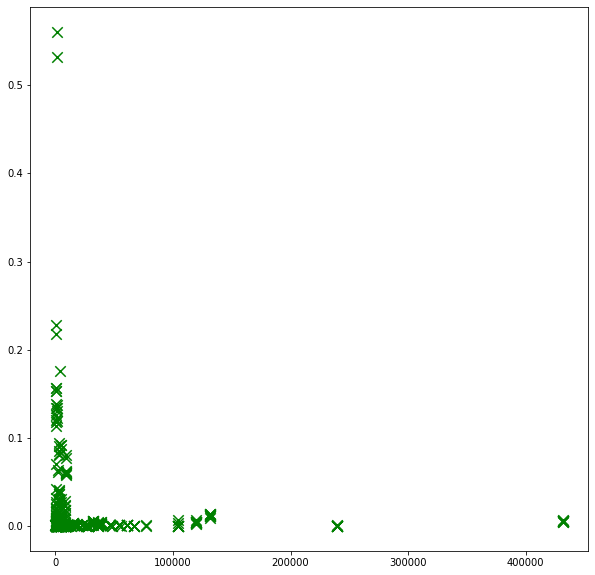

In [386]:
# plot winning-alg-class by feats...
import matplotlib.pyplot as plt

df = best_alg_df_dict["Accuracy"]

feat_comparison = [
    # "statistical.gravity",
    "general.nr_inst",
    # "general.inst_to_attr",
    # "statistical.nr_outliers",
    "statistical.cor.min",
    # "general.freq_class.count", # start xgb feats
    # "statistical.sparsity.histogram.0",
]

alg_type = df["alg_type"].astype(str).values
x = df["f__pymfe." + feat_comparison[0]].values
y = df["f__pymfe." + feat_comparison[1]].values

x_std = np.std(x)
y_std = np.std(y)

x_jit = x  # + np.random.rand(len(x)) * x_std * 0.001
y_jit = y  # + np.random.rand(len(y)) * y_std * 0.001

style_dict = {
    "{'neural'}": {
        "marker": "x",
        "color": "blue",
        },
    "{'trees', 'neural'}": {
        "marker": "*",
        "color": "purple",
        },
    "{'neural', 'baseline'}": {
        "marker": "+",
        "color": "blue",
         },
    "{'trees', 'neural', 'baseline'}": {
        "marker": "+",
        "color": "red",
        },
    "{'trees', 'baseline'}": {
        "marker": "+",
        "color": "green",
        },
    "{'baseline'}": {
        "marker": "+",
        "color": "black",
        },
    "{'trees'}": {
        "marker": "x",
        "color": "green",
    },
}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for t in set(alg_type):
    type_inds = alg_type == t

    ax.scatter(x_jit[type_inds], y_jit[type_inds], label=t, s=110, **style_dict[t])

ax.legend()
ax.set_xlabel(feat_comparison[0])
ax.set_ylabel(feat_comparison[1])

ax.set_yscale("log")
ax.set_xscale("log")

plt.tight_layout()
